In [55]:
!pip install numpy
!pip install matplotlib
!pip install plotly
!pip install networkx

### Importing Necessary Packages

In this cell, we import the essential packages required for the implementation and visualization of our Q-learning agent and GridWorld environment. The imported libraries include:

- **NumPy** (`numpy`): A fundamental package for numerical computing in Python, providing support for arrays and a variety of mathematical functions.

- **Matplotlib** (`matplotlib.pyplot` and `matplotlib.animation`): A library for creating static, interactive, and animated visualizations in Python. `pyplot` is used for plotting graphs and `animation` for creating animations.

- **Plotly** (`plotly.graph_objects`, `plotly.subplots`, and `plotly.io`): A graphing library that enables interactive plots and dashboards. `graph_objects` provides a way to create detailed and customizable plots, `subplots` helps in creating complex layouts, and `io` handles rendering and saving plots. The default renderer is set to `"browser"` to view plots in a web browser.

- **NetworkX** (`networkx`): A library for the creation, manipulation, and study of complex networks (graphs). It is useful for visualizing network structures and relationships.

In [56]:
#import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "browser"
import networkx as nx

In [57]:
np.random.seed(777)

### GridWorld Class

The `GridWorld` class represents the environment in which the Q-learning agent operates. It provides the functionality to initialize the grid, generate starting locations, determine the next location based on an action, and check terminal states.

#### Initialization

- `__init__(self, n=5)`: This constructor initializes the grid world with the following parameters:
  - `n`: Size of the grid. By default, the grid is `n x n` where `n=5`.
  - `self.B`: Coordinates of the base (goal location) set to `(n - 1, n - 1)`.
  - `self.actions`: List of possible actions the agent can take (`'up'`, `'right'`, `'down'`, `'left'`).
  - `self.action_space`: Number of possible actions, which is the length of `self.actions`.

#### Methods

- `get_starting_locations(self)`: 
  - Randomly generates starting locations for both the agent and the package, ensuring that neither the agent nor the package starts at the base location.
  - Returns the initial positions of the agent and package as `(agent_row, agent_col, package_row, package_col)`.

- `get_next_location(self, agent_row, agent_col, action_index)`:
  - Computes the next position of the agent based on the action taken.
  - Takes into account grid boundaries to prevent invalid moves.
  - Returns the new position `(new_row, new_col)`.

- `is_terminal_state(self, agent_row, agent_col, carrying)`:
  - Checks if the current state is terminal. The state is terminal if the agent is at the base location and is carrying the package.
  - Returns `True` if it is a terminal state, otherwise `False`.


In [58]:
class GridWorld:
    """
    This class represents the grid world for the agent.

    Attributes:
    n: int
        Size of grid world (n x n).
    B: tuple
        Cooordinates of target location where the package is to be delivered.
    actions: list
        List of actions the agent can take.
    action_space: int
        Number of possible actions.
    """

    def __init__(self, n=5):
        """
        Initialises the grid with a given size.
        """
        self.n = n
        self.B = (n - 1, n - 1) 
        self.actions = ['up', 'right', 'down', 'left']
        self.action_space = len(self.actions)

    def get_starting_locations(self):
        """
        Generates random starting positions for the agent and the package.

        Returns:
        tuple:
            Coordinates of the agent and package.
        """
        agent_row = np.random.randint(self.n)
        agent_col = np.random.randint(self.n)
        package_row = np.random.randint(self.n)
        package_col = np.random.randint(self.n)
        
        return agent_row, agent_col, package_row, package_col

    def get_next_location(self, agent_row, agent_col, action_index):
        """
        Gets the agent's next location based on the current location and the action chosen.

        Args:
        agent_row: int
            The current row of the agent in the grid.
        agent_col: int
            The current column of the agent in the grid.
        action_index: int
            Index of the chosen action from the actions list.

        Returns:
        tuple:
            New coordinates of the agent after the action is taken.
        """
        new_row, new_col = agent_row, agent_col # Assign new location as current location
        action = self.actions[action_index] # Get the action based from the actions list
        # Update location by moving agent's row or column
        if action == 'up' and agent_row > 0:
            new_row -= 1 
        elif action == 'right' and agent_col < self.n - 1:
            new_col += 1
        elif action == 'down' and agent_row < self.n - 1:
            new_row += 1
        elif action == 'left' and agent_col > 0:
            new_col -= 1
        return new_row, new_col

    def is_terminal_state(self, agent_row, agent_col, carrying):
        """
        Checks whether the package has been delivered to target location.

        Args:
        agent_row: int
            The current row of the agent in the grid.
        agent_col: int
            The current column of the agent in the grid.
        carrying: bool
            A boolean indicating whether the agent is carrying the package.

        Returns:
        bool:
            True if the package has been delivered, otherwise False.
        """
        # We reach the terminal state if the agent is carrying the package (carrying = True) and 
        # the agent has reached target location (self.B = True)
        return (agent_row, agent_col) == self.B and carrying

### QLearningAgent Class

The `QLearningAgent` class implements the Q-learning algorithm, which is used to train the agent to make decisions within the `GridWorld` environment. It manages Q-values, selects actions, and updates Q-values based on the agent's experiences.

#### Initialization

- `__init__(self, grid_world, learning_rate=0.1, discount_factor=0.95, epsilon=0.9)`:
  - Initializes the Q-learning agent with the following parameters:
    - `grid_world`: An instance of the `GridWorld` class.
    - `self.q_values`: Q-values for all state-action pairs, initialized randomly. The shape of this array is `(n, n, n, n, 2, action_space)`, where `2` corresponds to the carrying state (0 or 1).
    - `self.learning_rate`: Learning rate \( alpha \) that controls how much new information overrides old values.
    - `self.discount_factor`: Discount factor \( gamma \) which determines the importance of future rewards.
    - `self.epsilon`: Epsilon for the epsilon-greedy policy, balancing exploration and exploitation.
    - `self.rewards`: Dictionary of rewards for different actions (`'delivery'`, `'move'`, `'pickup'`).

#### Methods

- `get_next_action(self, agent_row, agent_col, package_row, package_col, carrying)`:
  - Selects the next action for the agent based on the epsilon-greedy policy.
  - With probability `epsilon`, chooses the action with the highest Q-value. Otherwise, selects a random action.
  - Returns the index of the selected action.

- `update_q_values(self, old_state, action_index, reward, new_state)`:
  - Updates the Q-values using the Q-learning update rule.
  - Computes the temporal difference and updates the Q-value for the given old state and action based on the reward received and the maximum Q-value for the new state.


In [59]:
class QLearningAgent:
    """
    This class represents the agent that will learn the task of picking up the package and delivering it to the location over the training process.
    Attributes:
        grid_world: An object of the GridWorld class that represents the grid that the agent will be put into to learn the task
        learning_rate: A float value that represents the rate at which the agent learns the task
        discount_factor: A float value that is used to calculate the discounted future rewards
    """
    def __init__(self, grid_world, learning_rate=0.15, discount_factor=0.9):
        """
        The init function initializes the object parameters when the agent object is created. 
        Args: 
            self: The Q_Learning agent that has been created.
            grid_world: An object of class GridWorld, in which the agent learns the task.
            learning_rate: The rate at which the agent learns the task / The rate at which the Q-values are updated.
            discount_factor: Represents the factor used to calculate the discounted future rewards.
        Returns:
            The init function does not return anything
        """

        #Initialize the parameters

        self.grid_world = grid_world # Represents the grid the agent is in
        self.q_values = np.random.rand(grid_world.n, grid_world.n, grid_world.n, grid_world.n, 2, grid_world.action_space) # Initialize the Q-table to random values
        self.learning_rate = learning_rate 
        self.discount_factor = discount_factor
        self.rewards = {
            'delivery': 80,
            'move': -1,
            'pickup': 20
        } # Represents the reward structure for the agent. 

    def get_next_action(self, agent_row, agent_col, package_row, package_col, carrying, epsilon):
        """
        This function is responsible for policy selection. Based on the value of epsilon passed, the function picks the next action the agent should take.
        Args:
            self: The Q-learning agent that invoked the function.
            agent_row: Represents which row the agent is in.
            agent_col: Represents which column the agent is in.
            package_row: Represents which row the package is in.
            package_col: Represents which column the package is in.
            carrying: A flag that represents whether the agent is carrying the package or not.
            epsilon: Represents the chance by which the agent picks a random action instead of picking an action based on the Q-values.
        Returns:
            The function returns the index of the action it picks.
        """

        # Generate a random number between 0 and 1. If the number is greater than epsilon, pick a random action. If not, pick an action based on the max Q-value
        if np.random.rand() < epsilon:
            return np.argmax(self.q_values[agent_row, agent_col, package_row, package_col, carrying])
        else:
            return np.random.randint(self.grid_world.action_space)

    def update_q_values(self, old_state, action_index, reward, new_state, is_terminal_state):
        """
        This function is responsible for updating the Q-table. 
        Args:
            self: The Q-learning agent that invoked the function.
            old_state: Represents the old state of the agent before the action was performed.
            action_index: an integer between 1 and 4 that represents the index of the action chosen by the get_next_action() method.
            reward: Represents the reward the agent gets after performing the action.
            new_state: Represents the new state of the agent after the action was performed.
            is_terminal_state: A flag that indicates whether the agent has reached a terminal state or not.
        Returns:
            The function does not return anything.
        """
        # If the agent is at a terminal state, the temporal difference is calculated differently, as the Q value for the new state is 0
        # Check if the agent is at a terminal state
        if not is_terminal_state:
            # Calculate the Q value as usual and update the Q-table
            old_q_value = self.q_values[old_state][action_index]
            temporal_difference = reward + (self.discount_factor * np.max(self.q_values[new_state])) - old_q_value
            self.q_values[old_state][action_index] = old_q_value + (self.learning_rate * temporal_difference)
        else:
            # Calculate the Q value, where temporal difference is just reward - old_q_value, and update the Q-table.
            old_q_value = self.q_values[old_state][action_index]
            temporal_difference = reward - old_q_value
            self.q_values[old_state][action_index] = old_q_value + (self.learning_rate * temporal_difference)

### Training Class

The `Training` class is responsible for training the Q-learning agent within the `GridWorld` environment. This process involves running multiple episodes where the agent interacts with the environment, learns from the rewards, and updates its Q-values to improve performance.

#### Initialization

- `__init__(self, agent, grid_world, num_episodes=100000, max_steps_per_episode=200)`: This constructor initializes the training parameters:
  - `agent`: An instance of the `QLearningAgent` class.
  - `grid_world`: An instance of the `GridWorld` class.
  - `num_episodes`: The number of training episodes to run.
  - `max_steps_per_episode`: The maximum number of steps to take per episode.

#### Training Process

The `train(self)` method executes the training loop, which involves:

1. **Episode Loop**: Iterates through the specified number of episodes (`num_episodes`).
   - **Starting Locations**: For each episode, the agent and package start at random locations obtained from `grid_world.get_starting_locations()`. The agent starts without carrying the package (`carrying = 0`).

2. **Step Loop**: Within each episode, the agent takes actions for a maximum of `max_steps_per_episode` steps:
   - **Action Selection**: The agent selects an action based on its policy using `self.agent.get_next_action()`. This method implements the epsilon-greedy strategy, where the agent chooses the action with the highest Q-value with probability `epsilon`.
   - **State Transition**: The agent moves to a new location based on the selected action using `grid_world.get_next_location()`.

3. **Reward Calculation**: After moving, the agent receives a reward based on its new state:
   - **Pickup**: If the agent reaches the package location and is not carrying the package, it receives a `pickup` reward.
   - **Delivery**: If the agent reaches the base location while carrying the package, it receives a `delivery` reward.
   - **Move**: For all other moves, the agent receives a `move` penalty.

4. **Q-Value Update**: The Q-values are updated using the Q-learning update rule. The update involves the following:

   - Applies the Bellman equation for Q-learning:
    ```
    Q(s, a) = Q(s, a) + α * [r + γ * max_a'(Q(s', a')) - Q(s, a)]
    ```
    where:
    - `Q(s, a)` is the current Q-value.
    - `α` is the learning rate.
    - `r` is the reward.
    - `γ` is the discount factor.
    - `max_a'(Q(s', a'))` is the maximum Q-value for the next state `s'` over all possible actions.

   The `update_q_values()` method in the `QLearningAgent` class applies this formula to adjust the Q-values based on the observed transition from state \( s \) to \( s' \) and the reward \( r \).

5. **Terminal State Check**: If the agent reaches a terminal state, the episode ends early.


In [60]:
class Training:
    """
    This class manages the training process of the agent in the grid world.

    Attributes:
    agent: object
        The agent to be trained.
    grid_world: object
        The grid world.
    num_episodes: int
        Number of training episodes.
    max_steps_per_episode: int
        Maximum number of steps per episode.
    epsilon: float
        Initial exploration rate for the epsilon-greedy algorithm.
    success_rates: list
        All the success rates taken after each episode.
    episode_lengths: list
        Lengths of each episode.
    pickup_completion_rates: list
        Rates of all the successful pickups.
    delivery_completion_rates: list
        Rates of all the successful deliveries.
    path: dict
        Stores the agent's paths for each episode.
    total_successes: int
        Count of all successful episodes.
    total_pickups: int
        Count of all successful pickups.
    total_deliveries: int
        Count of all successful deliveries.
    q_value_diffs: list
        Stores the sum of the Q-value differences between the old and new Q-values after each episode.
    """
    def __init__(self, agent, grid_world, num_episodes=100000, max_steps_per_episode=200, epsilon=0.9):
        """
        Initialises the training process with given parameters.
        Args: 
            self: The training object that has newly been created.
            agent: An object of QLearningAgent class that goes through the training process.
            grid_world: An object of GridWorld class that represents the environment the agent is placed in.
            num_episodes: An integer that represents the number of episodes the training process goes on for.
            max_steps_per_episode: An integer that represents the maximum number of steps the agent can take per episode.
            epsilon: A float value that is used to implement epsilon greedy algorithm. Influences the next action the agent chooses.
        """

        # Initialize the parameters for the training process
        self.agent = agent
        self.grid_world = grid_world
        self.num_episodes = num_episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.epsilon = epsilon

        # The following parameters are used to keep track of agent performance.
        self.success_rates = [] # Stores the success rate of the agent throughout the training process
        self.episode_lengths = [] # Stores the number of steps the agent takes to complete the task for each episode
        self.pickup_completion_rates = [] # Stores the rate of package pick-up over the training process
        self.delivery_completion_rates = [] # Stores the rate of delivery completion over the training process
        self.path = {} # A dictionary used to store the path the agent took to the destination over each episode


        self.total_successes = 0 
        self.total_pickups = 0 # keeping track of the number of pickups
        self.total_deliveries = 0 # keeping track of the number of successful deliveries
        self.q_value_diffs = []  # For q value convergence
        

    def train(self):
        """
        Trains the agent using Q-Learning over a number of episodes.
        Args:
            self: The training object that invokes the train() method.
        Returns:
            The training function does not return anything.
        """

        # Run  the training loop for the number of episodes initialized
        for episode in range(self.num_episodes):

            # Initialize the starting locations of the agent and package
            agent_row, agent_col, package_row, package_col = self.grid_world.get_starting_locations()

            # Set the carrying flag to 0, representing the agent is not carrying the package
            carrying = 0

            # Counter to keep track of the number of steps taken by the agent during the current episode
            steps = 0

            # Copy the the old Q-values to calculate Q-value diffs after agent finishes current episode
            old_q_values = np.copy(self.agent.q_values)
            
            # List to maintain the path taken by the agent to complete the task
            tracker = []

            for step in range(self.max_steps_per_episode):

                # Get the next action the agent performs 
                action_index = self.agent.get_next_action(agent_row, agent_col, package_row, package_col, carrying, self.epsilon)

                # Implementing epsilon decay to improve agent performance
                self.epsilon += 0.000009

                # Update the agent position based on the action_index
                new_agent_row, new_agent_col = self.grid_world.get_next_location(agent_row, agent_col, action_index)

                # Check if agent picks up the package
                if (new_agent_row, new_agent_col) == (package_row, package_col) and not carrying:
                    reward = self.agent.rewards['pickup']

                    # Update pickup counter
                    self.total_pickups += 1
                    # Updtae carrying flag to 1
                    carrying = 1
                # Check if the agent reaches the destination with the package
                elif (new_agent_row, new_agent_col) == self.grid_world.B and carrying:
                    reward = self.agent.rewards['delivery']

                    # Update the deliveries counter
                    self.total_deliveries += 1
                    
                else:
                    reward = self.agent.rewards['move']

                # Store state information to update the Q-table
                old_state = (agent_row, agent_col, package_row, package_col, carrying)
                new_state = (new_agent_row, new_agent_col, package_row, package_col, carrying)

                # Update the Q-table
                self.agent.update_q_values(old_state, action_index, reward, new_state, self.grid_world.is_terminal_state(agent_row, agent_col, carrying))

                # Append the path taken by the agent to the tracker list
                tracker.append(old_state)

                # Increment the step count
                steps += 1

                # Update the agent position
                agent_row, agent_col = new_agent_row, new_agent_col

                # Check if the agent reached the destination with the package
                if self.grid_world.is_terminal_state(agent_row, agent_col, carrying):
                    # Update success count
                    self.total_successes += 1
                    # Append the final position to the tracker list
                    tracker.append(new_state)
                    break
            
            # Calculate success rate and add it to the success_rates list
            success_rate = self.total_successes / (episode + 1)
            self.success_rates.append(success_rate)

            # Add number of steps taken to complete the task to the episode_length list
            self.episode_lengths.append(steps)

            # Calculate pickup and delivery rates and update corresponding lists
            pickup_rate = self.total_pickups / (episode + 1)
            delivery_rate = self.total_deliveries / (episode + 1)
            self.pickup_completion_rates.append(pickup_rate)
            self.delivery_completion_rates.append(delivery_rate)

            # Calculate the difference in the old and new Q-Values, and take their sum
            q_value_diff = np.abs(self.agent.q_values - old_q_values).sum()
            # Append the previously obtained sum to the corresponding list
            self.q_value_diffs.append(q_value_diff)
            
            #Add the path taken by the agent in the current episode to the path dictionary
            self.path[episode] = tracker
            
            
        print('Training complete!')

### Testing Class

The `Testing` class is responsible for evaluating the performance of the trained Q-learning agent. It executes several test episodes to assess how well the agent has learned to navigate the `GridWorld` environment and accomplish its tasks.

#### Initialization

- `__init__(self, agent, grid_world, max_steps_per_episode=200)`:
  - Initializes the testing parameters:
    - `agent`: An instance of the `QLearningAgent` class that has been trained.
    - `grid_world`: An instance of the `GridWorld` class used for running test episodes.
    - `max_steps_per_episode`: The maximum number of steps allowed per test episode.

#### Testing Process

The `test_agent(self, num_tests=10)` method runs a specified number of test episodes to evaluate the agent's performance. It involves the following steps:

1. **Initialization**:
   - `success_count`: A counter to keep track of the number of successful test episodes where the agent successfully delivers the package to the base.

2. **Test Loop**:
   - For each test episode:
     - **Starting Locations**: The agent and package start at random locations, similar to the training phase, using `grid_world.get_starting_locations()`. The agent begins without carrying the package (`carrying = 0`).
     - **Path Tracking**: Initializes a list to track the path taken by the agent during the episode.
   
3. **Action Execution**:
   - The agent selects actions based on its learned policy using `self.agent.get_next_action()`.
   - The agent's position is updated according to the selected action using `grid_world.get_next_location()`.
   - The path taken by the agent is recorded.

4. **State and Success Check**:
   - If the agent reaches the package location and is not carrying the package, it picks up the package (`carrying = 1`).
   - If the agent reaches the base location while carrying the package, the episode is considered a success.
   - The episode terminates early if the agent reaches the terminal state or if the maximum number of steps is reached.

5. **Results Reporting**:
   - After completing all test episodes, the success rate is calculated.
   - The path taken by the agent for each test episode is displayed.
   - The overall success rate across all test episodes is reported.


In [61]:
class Testing:
    """
    This class is used to test the Q-learning agent after the trainig process.
    Attributes:
        self: The testing object that has been created.
        agent: An object of QLearningAgent class that needs to tested for it's performance.
        grid_world: An object of GridWorld class that represents the environment.
        max_steps_per_episode: An integer that represents the maximum number of steps the agent can take per episode.
    """
    def __init__(self, agent, grid_world, max_steps_per_episode=200):
        """
        The init method initializes the required parameters to test the Q-learning agent.
        Args:
            self: The testing object that has been created.
            agent: An object of QLearningAgent class that needs to tested for it's performance.
            grid_world: An object of GridWorld class that represents the environment.
            max_steps_per_episode: An integer that represents the maximum number of steps the agent can take per episode.
        Returns:
            The init method does not return anything.
        """
        self.agent = agent
        self.grid_world = grid_world
        self.max_steps_per_episode = max_steps_per_episode

    def test_agent(self, num_tests=10):
        """
        This method tests the agent performance by measuring the number of times the Q-learning agent was successfully able to complete the delivery.
        Args:
            self: The testing object that invoked the test_agent() method.
            num_tests: An integer that represents the number of tests that are to be run.
        Returns:
            The test_agent() method does not return anything.
        """

        # A counter to keep track of the number of successful runs.
        success_count = 0
        for _ in range(num_tests):
            # Initialize agent and package positions
            agent_row, agent_col, package_row, package_col = self.grid_world.get_starting_locations()

            # Initialize carrying flag to 0, representing the agent is not carrying the package.
            carrying = 0

            # Use a list to keep track of the path taken by the agent to finish the task
            path = [(agent_row, agent_col)]
            for step in range(self.max_steps_per_episode):
                # Get the next action that the agent should perform. Epsilon is set to 1.0, as we are testing the agent and we don't want the agent to choose a random action.
                action_index = self.agent.get_next_action(agent_row, agent_col, package_row, package_col, carrying, epsilon=1.0)

                # Update the location of the agent based on the action performed.
                agent_row, agent_col = self.grid_world.get_next_location(agent_row, agent_col, action_index)
                path.append((agent_row, agent_col))

                # Check if the agent reaches the package location set the carrying flag to 1 if so.
                if (agent_row, agent_col) == (package_row, package_col) and not carrying:
                    carrying = 1

                # Check if the agent reaches the destination location with the package. If so, update the success count.
                if self.grid_world.is_terminal_state(agent_row, agent_col, carrying):
                    success_count += 1
                    print('Success')
                    break
            print(f'Path taken by agent for package location: {(package_row, package_col)} - ')
            print(path)
        print(f'Success rate: {success_count}/{num_tests}')

    def heuristic(self, a, b):
        """
        This function defines the heuristic we use to measure the agent performance. We are using Manhattan distance as the heristic
        """
        return abs(a[0] - b[0]) + abs(a[1] - b[1])
    
    def test_against_Astar(self, num_tests = 1000):
        """
        This function tests the agents' performance against the A* pathfinding algorithm. The A* algorithm has been divided into 2 parts - 
        agent_location -> package and package_location -> destination.
        The optimal path for both of these parts are calculated using A* algorithm and this path is compared with the path the agent took to reach the
        destination. The rate of optimal path taken by the agent is reported at the end.
        Args:
            self: The testing object that invoked the method.
            num_tests: An integer that represents the number of tests to be run.
        Returns:
            The test_against_Astar() function does not return anything. 
        """
        success_count = 0
        # Create a grid for A*
        G = nx.grid_2d_graph(self.grid_world.n, self.grid_world.n)  # 5x5 grid
        no_optimal_paths = 0
        
        for _ in range(num_tests):
            agent_row, agent_col, package_row, package_col = self.grid_world.get_starting_locations()
            
            # Finding the optimal path using A*
            start = (agent_row,agent_col)
            package = (package_row, package_col)
            goal = self.grid_world.B
            opt_path_pkg = nx.astar_path(G, start, package, heuristic=self.heuristic)
            opt_path_goal = nx.astar_path(G, package, goal, heuristic=self.heuristic)

            # Testing the model
            carrying = 0
            path = [(agent_row, agent_col)]
            for step in range(self.max_steps_per_episode):
                action_index = self.agent.get_next_action(agent_row, agent_col, package_row, package_col, carrying, 1.0)
                agent_row, agent_col = self.grid_world.get_next_location(agent_row, agent_col, action_index)
                path.append((agent_row, agent_col))
                if (agent_row, agent_col) == (package_row, package_col) and not carrying:
                    carrying = 1
                if self.grid_world.is_terminal_state(agent_row, agent_col, carrying):
                    success_count += 1
                    break

            print(f'Path taken by agent for package location: {(package_row, package_col)} - ')
            print(path)
            
            # Finding how many optimal paths the model took compared to A*
            if len(path) == len(opt_path_pkg)+len(opt_path_goal)-1:
                no_optimal_paths+=1
                
        print(f'Success rate: {success_count}/{num_tests}')
        print(f'Optimal path rate: {no_optimal_paths}/{num_tests}')
    

In [62]:
# Create the objects necessary to perform the Q-Learning task and train the agent using the trainer object.

grid_world = GridWorld()
agent = QLearningAgent(grid_world)
trainer = Training(agent, grid_world)
trainer.train()

Training complete!


In [63]:
# Create the testing object and test the agent performance over 10000 test runs.

tester = Testing(agent, grid_world)
tester.test_agent(num_tests=10000)
tester.test_against_Astar(num_tests=1000)

Success
Path taken by agent for package location: (1, 1) - 
[(4, 2), (4, 1), (3, 1), (2, 1), (1, 1), (2, 1), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)]
Success
Path taken by agent for package location: (2, 1) - 
[(2, 4), (2, 3), (2, 2), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (4, 3) - 
[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)]
Success
Path taken by agent for package location: (2, 2) - 
[(0, 2), (1, 2), (2, 2), (3, 2), (3, 3), (4, 3), (4, 4)]
Success
Path taken by agent for package location: (3, 0) - 
[(1, 3), (1, 2), (2, 2), (3, 2), (3, 1), (3, 0), (3, 1), (3, 2), (3, 3), (2, 3), (2, 4), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (2, 0) - 
[(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (0, 3) - 
[(2, 1), (1, 1), (1, 2), (1, 3), (0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4)]
Success
Path taken by agent f

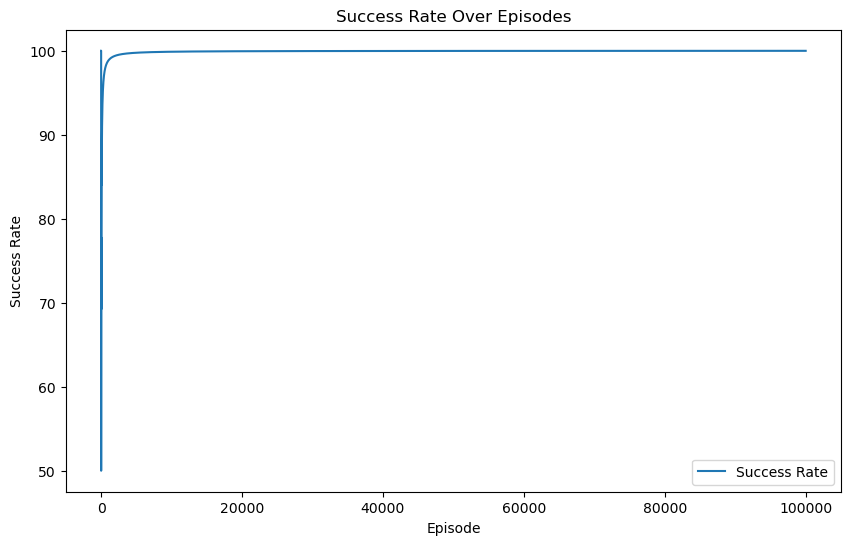

In [64]:
# Success Rate per total episodes
plt.figure(figsize=(10, 6))
plt.plot([rate*100 for rate in trainer.success_rates], label="Success Rate")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Success Rate Over Episodes")
plt.legend()
plt.show()

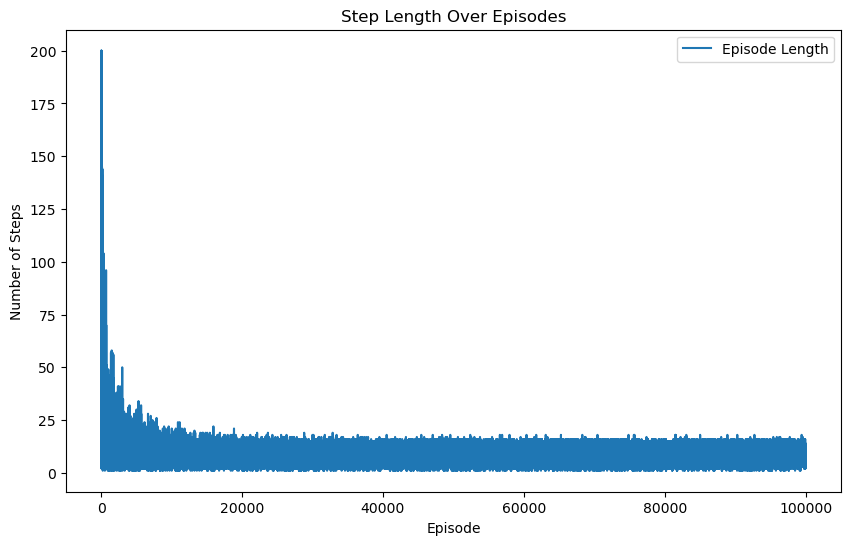

In [65]:
# No. of steps taken per episode
plt.figure(figsize=(10, 6))
plt.plot(trainer.episode_lengths, label="Episode Length")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")
plt.title("Step Length Over Episodes")
plt.legend()
plt.show()

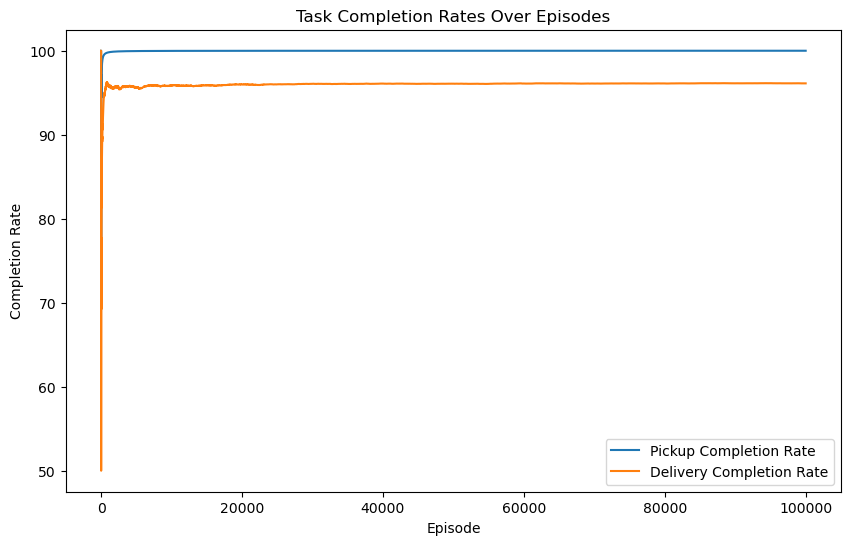

In [66]:
# Task Completion Rates for pickups and deliveries
plt.figure(figsize=(10, 6))
plt.plot([pickup*100 for pickup in trainer.pickup_completion_rates], label="Pickup Completion Rate")
plt.plot([delivery*100 for delivery in trainer.delivery_completion_rates], label="Delivery Completion Rate")
plt.xlabel("Episode")
plt.ylabel("Completion Rate")
plt.title("Task Completion Rates Over Episodes")
plt.legend()
plt.show()

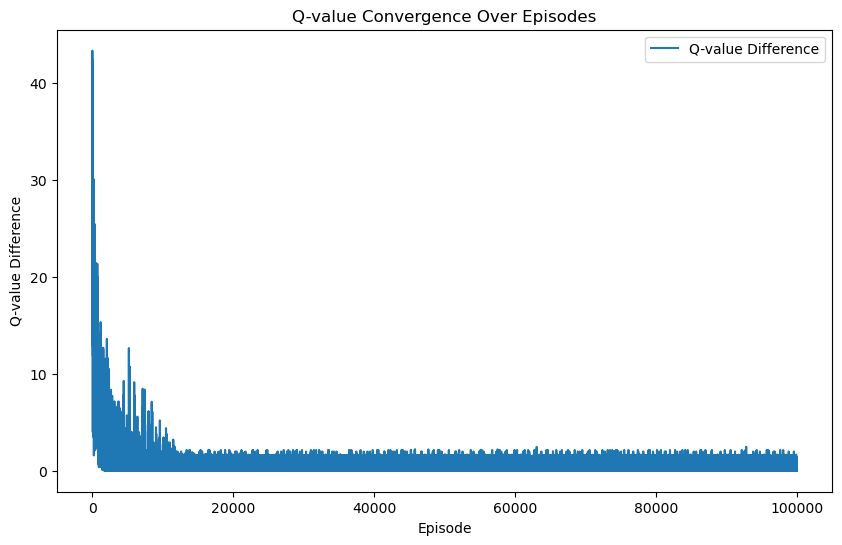

In [67]:
# Q-value Convergence
plt.figure(figsize=(10, 6))
plt.plot(trainer.q_value_diffs, label="Q-value Difference")
plt.xlabel("Episode")
plt.ylabel("Q-value Difference")
plt.title("Q-value Convergence Over Episodes")
plt.legend()
plt.show()

In [68]:
class Visualize:
    """
    Handles visualization of the agent's movements within the grid world.

    Attributes:
    grid: np.ndarray
        A 2D grid representing the grid environment.
    grid_world: object
        The grid world environment where the agent operates.
    agent: object
        The agent whose movements are being visualized.
    trainer: object
        Instance controlling the training process.
    carry_flag: int
        Indicates whether the agent is carrying the package (1 if carrying, 0 if otherwise).
    """
    def __init__(self, grid_world, agent, trainer):
        """
        Initializes the visualization with the grid world, agent, and trainer.
        """
        self.grid = np.zeros((grid_world.n, grid_world.n))
        self.grid_world = grid_world
        self.agent = agent
        self.trainer = trainer
        self.carry_flag = 0


    # Visualization function
    def visualize_movement(self, agent_positions, package_location, target_location):
        """
        Generates frames for an animation of the agent's movement in the grid.

        Args:
        agent_positions: list of tuples
            The sequence of tuples representing the agent's positions.
        package_location: tuple
            Starting location of the package.
        target_location: tuple
            Target location for package delivery.

        Returns:
        frames: list of go.Frame
            Frames representing the agent's movement animation.
        """
        frames = []
        for i, pos in enumerate(agent_positions):

            # Is the agent carrying the package?
            if (pos == package_location):
                self.carry_flag = 1 # agent picks up the package

            # Create the grid in the animation
            grid_trace = go.Scatter(
                x=[0, self.grid_world.n, self.grid_world.n, 0, 0],
                y=[self.grid_world.n, self.grid_world.n, 0, 0, self.grid_world.n],
                mode='lines',
                line=dict(color='black'),
                showlegend=False
            )
            
            # Create the agent in the animation
            agent_trace = go.Scatter(
                x=[pos[1] + 0.5],
                y=[self.grid_world.n - (pos[0] + 0.5)],
                mode='markers',
                marker=dict(size=15, color='red'),
                name='Agent'
            )

            # Create the package in the animation
            if self.carry_flag == 0: # if not picked up, package is visible
                package_trace = go.Scatter(
                    x=[package_location[1] + 0.5],
                    y=[self.grid_world.n - (package_location[0] + 0.5)],
                    mode='markers',
                    marker=dict(size=12, color='blue', symbol='square'),
                    name='Package'
                )
            elif self.carry_flag == 1: # if picked up, package is not visble anymore
                package_trace = go.Scatter(x=[], y=[], mode='markers', name='Package (Picked Up)')

            # Create the target
            target_trace = go.Scatter(
                x=[target_location[1] + 0.5],
                y=[self.grid_world.n - (target_location[0] + 0.5)],
                mode='markers',
                marker=dict(size=12, color='green', symbol='star'),
                name='Target'
            )
            
            # Create a frame for the current state of the game and append this to the frames list
            frame = go.Frame(data=[grid_trace, agent_trace, package_trace, target_trace])
            frames.append(frame)

        return frames
    
    def simulate_agent_movement(self):
        """
        Simulates the agent's movement in the grid for an episode to be used after training the testing the agent.

        Returns:
        path: list of tuples
            Sequence of agent positions during the episode.
        package_location: tuple
            Initial location of the package.
        """
        agent_row, agent_col, package_row, package_col = self.grid_world.get_starting_locations()
        carrying = 0 # Carrying flag to represent if the agent is carrying the package
        path = [(agent_row, agent_col)]

        # Simulate the movement of agent
        for step in range(self.trainer.max_steps_per_episode):
            # Get the next action of the agent
            action_index = self.agent.get_next_action(agent_row, agent_col, package_row, package_col, carrying, 1.0)
            # get new position of agent as a tuple 
            agent_row, agent_col = self.grid_world.get_next_location(agent_row, agent_col, action_index)
            path.append((agent_row, agent_col)) # append new position of agent to path list
            # Check if agent has reached the package loction and is not carrying yet
            if (agent_row, agent_col) == (package_row, package_col) and not carrying:
                carrying = 1
            # Check if agent has reached terminal state
            if self.grid_world.is_terminal_state(agent_row, agent_col, carrying):
                break # end the episode

        
        
        return path, (package_row, package_col)


In [69]:
# Visualisation during training process

visualizer = Visualize(grid_world, agent, trainer) # initialise the visualise class

episode = 100 # Change this to the episode number you would like to see during training 
agent_positions = []
package_location = []
iter = trainer.path[episode] # This is the path taken by the agent in the specified episode
for i in iter:
    pos = (i[0], i[1]) # Getting the specific agent position in the path
    agent_positions.append(pos)

package_location = (iter[0][2], iter[0][3]) # Getting the package location in the specified episode
print(package_location)

# Generate the frames that visualise the episode
frames = visualizer.visualize_movement(agent_positions, package_location, (grid_world.n - 1, grid_world.n - 1))

(4, 2)


In [70]:
fig = go.Figure( # Creating the plotly figure object
    # Initialising the figure with frame data
    data=[frames[0].data[0], frames[0].data[1], frames[0].data[2], frames[0].data[3]], 
    # Layout of the figure
    layout=go.Layout(
        # setting the x-axis properties
        xaxis=dict(range=[-1, grid_world.n+1], showgrid=True, zeroline=False, showticklabels=False),
        # setting the y-axis properties
        yaxis=dict(range=[-1, grid_world.n+1], showgrid=True, zeroline=False, showticklabels=False),
        # setting the title of the plot
        title="Agent Movement Simulation During Training",
        # Adding play and pause buttons to control the animation
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration":500, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}])]
        )]
    ),
    frames=frames # including the frames in the figure
)

# Show the animation
fig.show()

In [71]:
# Visualisation after training and testing agent

visualizer = Visualize(grid_world, agent, trainer) # initialise the visualise class with the agent

# Simulating the agent's movement after training to obtain optimal path
agent_positions, package_location = visualizer.simulate_agent_movement()
# Generating the frames for the animation using the agent's movement
frames = visualizer.visualize_movement(agent_positions, package_location, (grid_world.n - 1, grid_world.n - 1))

In [72]:
fig = go.Figure( # Creating the plotly figure object
    # Initialising the figure with frame data
    data=[frames[0].data[0], frames[0].data[1], frames[0].data[2], frames[0].data[3]], 
    # Layout of the figure
    layout=go.Layout(
        # setting the x-axis properties
        xaxis=dict(range=[-1, grid_world.n+1], showgrid=True, zeroline=False, showticklabels=False),
        # setting the y-axis properties
        yaxis=dict(range=[-1, grid_world.n+1], showgrid=True, zeroline=False, showticklabels=False),
        # setting the title of the plot
        title="Agent Movement Simulation After Training",
        # Adding play and pause buttons to control the animation
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration":500, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}])]
        )]
    ),
    frames=frames # including the frames in the figure
)

# Show the animation
fig.show()